# Import the necessary packages 

In [1]:
import pandas as pd
import numpy as np
#import pandas_datareader.data as web
from datetime import date, datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols 
from sklearn.linear_model import LogisticRegression

# Load data sets & process data

In [2]:
#Load S&P 500 & Shanghai Index data
#spx is in EST
spx = pd.read_csv('../data/input/$spx_intraday-30min.csv')

#sse is in China time: GMT+8 --> need to subtract 13 hours to get EST
sse = pd.read_csv('../data/input/shanghai_index_30min.csv')
#baba is in EST
baba = pd.read_csv('../data/input/baba_intraday-30min.csv')

#Split Time into data and Time columns

spx['Date'] = [datetime.strftime(datetime.strptime(x.split(' ')[0], '%m/%d/%Y'),'%m/%d/%Y') for x in spx['Time']]
spx['Rounded_Time'] = [x.split(' ')[1] for x in spx['Time']]
spx = spx.iloc[spx[spx['Date']=='12/31/2019'].index[0]: spx[spx['Date']=='01/02/2018'].index[0],:]

sse['Date'] = [datetime.strftime(datetime.strptime(x.split(' ')[0], '%Y-%m-%d'),'%m/%d/%Y')for x in sse['trade_time']]
sse['Rounded_Time'] = [x.split(' ')[1][:-3] for x in sse['trade_time']]
sse = sse.iloc[sse[sse['Date']=='01/02/2018'].index[0]:sse[sse['Date']=='12/31/2019'].index[0],:]

baba['Date'] = [datetime.strftime(datetime.strptime(x.split(' ')[0], '%m/%d/%Y'),'%m/%d/%Y') for x in baba['Time']]
baba['Rounded_Time'] = [x.split(' ')[1] for x in baba['Time']]
baba = baba.iloc[baba[baba['Date']=='12/31/2019'].index[0]: baba[baba['Date']=='01/02/2018'].index[0],:]


In [3]:
#Calculate log Returns over 30 min increments
spx['Return'] = np.log(spx['Last'])- np.log(spx['Open'])
spx = spx.dropna()

sse['Return'] = np.log(sse['close'])- np.log(sse['open'])
sse = sse.dropna()

baba['Return'] = np.log(baba['Last'])- np.log(baba['Open'])
baba = baba.dropna()


In [6]:
#Load lstm balanced data set
#lstm_bal is in GMT/UTC time --> need to convert to EST time to regress against S&P prices
lstm_bal = pd.read_csv('../output/results/LSTM_balanced_results.csv',index_col=0)

#Rounding time to the closest half hour
def round_time(time):
    if int(time.split(':')[1])<30:
        return str(int(time.split(':')[0])-5)+':00'
    else:
        return str(int(time.split(':')[0])-5)+':30'
    
lstm_bal['Date'] = [datetime.strftime(datetime.strptime(x.split(' ')[0], '%Y-%m-%d'),'%m/%d/%Y') for x in lstm_bal['Date']]
lstm_bal['Rounded_Time'] = [round_time(x) for x in lstm_bal['Time']]

lstm_bal = lstm_bal[['Date','Time','Rounded_Time','outcome']]
lstm_bal.head(5)


,Date,Time,Rounded_Time,outcome
43,02/08/2018,12:44,7:30,-1
44,02/18/2018,6:33,1:30,1
45,03/07/2018,9:10,4:00,1
46,03/10/2018,10:15,5:00,-1
47,03/28/2018,5:16,0:00,1


In [324]:
#Load textblob data set
textblob = pd.read_csv('../output/results/textblob_prediction_data.csv',index_col=0)
   
textblob['Date'] = [datetime.strftime(datetime.strptime(x.split(' ')[0], '%m/%d/%Y'),'%m/%d/%Y') for x in textblob['date']]
textblob['Time'] = [x.split(' ')[1] for x in textblob['date']]
textblob['Rounded_Time'] = [round_time(x) for x in textblob['Time']]

textblob = textblob[['Date','Time','Rounded_Time','sentiment']]
textblob.head(5)

,Date,Time,Rounded_Time,sentiment
43,02/08/2018,12:44,12:30,0
44,02/18/2018,6:33,6:30,1
45,03/07/2018,9:10,9:00,1
46,03/10/2018,10:15,10:00,0
47,03/28/2018,5:16,5:00,-1


In [328]:
#Separate lstm_bal data set into Positive (positive tweets), & negative (negative tweets)
lstm_pos = lstm_bal[lstm_bal['outcome']==1]
lstm_neg = lstm_bal[lstm_bal['outcome']==-1]


In [311]:
#Separate textblob data set into Positive (positive tweets), & negative (negative tweets)
textblob_pos = textblob[textblob['sentiment']==1]
textblob_neg = textblob[textblob['sentiment']==-1]


In [329]:
#Commented out because the code takes long to run 
#Drop duplicates
lstm_neg = lstm_neg.drop_duplicates(subset=['Date', 'Rounded_Time'], keep='first')
lstm_pos = lstm_pos.drop_duplicates(subset=['Date', 'Rounded_Time'], keep='first')

#Drop rows of 30 min with conflicting sentiment tweets (both + and - in the same 30 min)
neg_drop_index = []
pos_drop_index = []

for i in range(0,lstm_neg.shape[0]):
    for j in range(0,lstm_pos.shape[0]):
        if lstm_neg.iloc[i,0]== lstm_pos.iloc[j,0] and lstm_neg.iloc[i,2]== lstm_pos.iloc[j,2]:
            neg_drop_index.append(i)
            pos_drop_index.append(j)

lstm_neg2 = lstm_neg.drop(lstm_neg.index[neg_drop_index])
lstm_pos2 = lstm_pos.drop(lstm_pos.index[pos_drop_index])

#Concatenating postive and negative tweets 
lstm_merged = pd.concat([lstm_neg2,lstm_pos2])
lstm_merged.to_csv('../output/results/lstm_merged.csv')

In [330]:
# Load lstm_merged data set
lstm_merged = pd.read_csv('../output/results/lstm_merged.csv')

In [312]:
#Commented out because the code takes long to run 
#Drop duplicates
textblob_neg = textblob_neg.drop_duplicates(subset=['Date', 'Rounded_Time'], keep='first')
textblob_pos = textblob_pos.drop_duplicates(subset=['Date', 'Rounded_Time'], keep='first')

#Drop rows of 30 min with conflicting sentiment tweets (both + and - in the same 30 min)
neg_drop_index = []
pos_drop_index = []

for i in range(0,textblob_neg.shape[0]):
    for j in range(0,textblob_pos.shape[0]):
        if textblob_neg.iloc[i,0]== textblob_pos.iloc[j,0] and textblob_neg.iloc[i,2]== textblob_pos.iloc[j,2]:
            neg_drop_index.append(i)
            pos_drop_index.append(j)

textblob_neg2 = textblob_neg.drop(textblob_neg.index[neg_drop_index])
textblob_pos2 = textblob_pos.drop(textblob_pos.index[pos_drop_index])

#Concatenating postive and negative tweets 
textblob_merged = pd.concat([textblob_neg2,textblob_pos2])
textblob_merged.to_csv('../output/results/textblob_merged.csv')

In [313]:
# Load textblob_merged data set
textblob_merged = pd.read_csv('../output/results/textblob_merged.csv')

# Merging financial data with sentiment data

## 1. Merging S&P 500 with lstm data set

           Date Rounded_Time    Return  Positive  Negative
12   12/31/2019        10:30 -0.000998         1         0
87   12/20/2019        15:00 -0.000623         0         1
436  11/18/2019        10:00 -0.000922         1         0
588  11/01/2019        16:00 -0.000013         1         0
616  10/31/2019         9:30 -0.002827         1         0


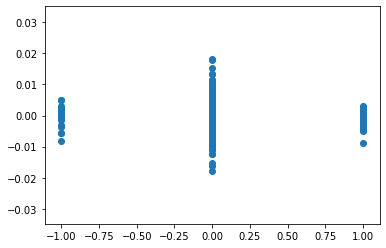

In [360]:
spx_reg = spx.merge(lstm_merged, how = 'outer', on = ['Date','Rounded_Time'])

#Drop unnecessary columns
spx_reg = spx_reg.drop(['High','Low','Volume','Change'],axis = 1)
spx_reg['outcome'] = spx_reg['outcome'].fillna(0)
spx_reg['Return'] = spx_reg['Return'].fillna(0)
#Drop rows with no change in price (0 Return) or with no tweet
spx_reg = spx_reg.drop(spx_reg[spx_reg['Return'] == 0].index)

plt.scatter( spx_reg['outcome'],spx_reg['Return'])

# fit_logit_pos = LogisticRegression()
# x = spx_reg['Return']
# y = spx_reg['outcome']
# fit_logit_pos.fit(x,y) 
# print(fit_logit_pos.summary())

#Assign Neutral to half hours with no tweet
spx_reg['Positive'] = (spx_reg['outcome'] == 1)
spx_reg['Negative'] = (spx_reg['outcome'] == -1)
#spx_reg['Neutral'] = (spx_reg['outcome'] == 0)

spx_reg = spx_reg[['Date','Rounded_Time','Return','Positive','Negative']]

spx_reg = spx_reg.drop(spx_reg[(spx_reg['Positive'] == 0) & (spx_reg['Negative']==0)].index)
spx_reg['Positive'] = [int(x==True) for x in spx_reg['Positive']]
spx_reg['Negative'] = [int(x==True) for x in spx_reg['Negative']]
#spx_reg['Neutral'] = [int(x==True) for x in spx_reg['Neutral']]

spx_reg.to_csv('../output/results/spx_reg.csv')
print(spx_reg.head(5))

## 2. Merging S&P 500 with textblob data set

In [332]:
spx_textblob = spx.merge(textblob_merged, how = 'outer', on = ['Date','Rounded_Time'])

#Drop unnecessary columns
spx_textblob = spx_textblob.drop(['High','Low','Volume','Change'],axis = 1)
spx_textblob['sentiment'] = spx_textblob['sentiment'].fillna(0)
spx_textblob['Return'] = spx_textblob['Return'].fillna(0)
spx_textblob = spx_textblob.drop(spx_textblob[spx_textblob['Return'] == 0].index)

#Assign Neutral to half hours with no tweet
spx_textblob['Positive'] = (spx_textblob['sentiment'] == 1)
spx_textblob['Negative'] = (spx_textblob['sentiment'] == -1)
#spx_textblob['Neutral'] = (spx_textblob['Sentiment'] == 0)

spx_textblob = spx_textblob[['Date','Rounded_Time','Return','Positive','Negative']]

spx_textblob = spx_textblob.drop(spx_textblob[(spx_textblob['Positive'] == 0) & (spx_textblob['Negative']==0)].index)
spx_textblob['Positive'] = [int(x==True) for x in spx_textblob['Positive']]
spx_textblob['Negative'] = [int(x==True) for x in spx_textblob['Negative']]
#spx_textblob['Neutral'] = [int(x==True) for x in spx_textblob['Neutral']]

spx_textblob.to_csv('../output/results/spx_textblob.csv')


## 3. Merging Shanghai Composite Index with lstm data set

In [333]:
sse_reg = sse.merge(lstm_merged, how = 'outer', on = ['Date','Rounded_Time'])

#Drop unnecessary columns
sse_reg = sse_reg.drop(['high','low','volume','money'],axis = 1)
sse_reg['outcome'] = sse_reg['outcome'].fillna(0)
sse_reg['Return'] = sse_reg['Return'].fillna(0)
sse_reg = sse_reg.drop(sse_reg[sse_reg['Return'] == 0].index)


#Assign Neutral to half hours with no tweet
sse_reg['Positive'] = (sse_reg['outcome'] == 1)
sse_reg['Negative'] = (sse_reg['outcome'] == -1)
#sse_reg['Neutral'] = (sse_reg['outcome'] == 0)

sse_reg = sse_reg[['Date','Rounded_Time','Return','Positive','Negative']]

sse_reg = sse_reg.drop(sse_reg[(sse_reg['Positive'] == 0) & (sse_reg['Negative']==0)].index)
sse_reg['Positive'] = [int(x==True) for x in sse_reg['Positive']]
sse_reg['Negative'] = [int(x==True) for x in sse_reg['Negative']]
#sse_reg['Neutral'] = [int(x==True) for x in sse_reg['Neutral']]

sse_reg.to_csv('../output/results/sse_reg.csv')


## 4. Merging Shanghai Composite Index with textblob data set

In [349]:
sse_textblob = sse.merge(textblob_merged, how = 'outer', on = ['Date','Rounded_Time'])

#Drop unnecessary columns
sse_textblob = sse_textblob.drop(['high','low','volume','money'],axis = 1)
sse_textblob['sentiment'] = sse_textblob['sentiment'].fillna(0)
sse_textblob['Return'] = sse_textblob['Return'].fillna(0)
sse_textblob = sse_textblob.drop(sse_textblob[sse_textblob['Return'] == 0].index)


#Assign Neutral to half hours with no tweet
sse_textblob['Positive'] = (sse_textblob['sentiment'] == 1)
sse_textblob['Negative'] = (sse_textblob['sentiment'] == -1)
#sse_textblob['Neutral'] = (sse_textblob['sentiment'] == 0)

sse_textblob = sse_textblob[['Date','Rounded_Time','Return','Positive','Negative']]

sse_textblob = sse_textblob.drop(sse_textblob[(sse_textblob['Positive'] == 0) & (sse_textblob['Negative']==0)].index)
sse_textblob['Positive'] = [int(x==True) for x in sse_textblob['Positive']]
sse_textblob['Negative'] = [int(x==True) for x in sse_textblob['Negative']]
#sse_textblob['Neutral'] = [int(x==True) for x in sse_textblob['Neutral']]

sse_textblob.to_csv('../output/results/sse_textblob.csv')
sse_textblob.head(5)

,Date,Rounded_Time,Return,Positive,Negative
198,02/05/2018,14:30,0.000198,1,0
420,03/22/2018,13:30,0.001090,1,0
450,03/28/2018,11:00,-0.000941,0,1
508,04/10/2018,13:30,-0.001987,1,0
525,04/12/2018,14:00,-0.002173,1,0


## 5. Merging Alibaba with lstm data set

In [341]:
baba_lstm = sse.merge(lstm_merged, how = 'outer', on = ['Date','Rounded_Time'])

#Drop unnecessary columns
baba_lstm = baba_lstm.drop(['high','low','volume','money'],axis = 1)
baba_lstm['outcome'] = baba_lstm['outcome'].fillna(0)
baba_lstm['Return'] = baba_lstm['Return'].fillna(0)
baba_lstm = baba_lstm.drop(baba_lstm[baba_lstm['Return'] == 0].index)


#Assign Neutral to half hours with no tweet
baba_lstm['Positive'] = (baba_lstm['outcome'] == 1)
baba_lstm['Negative'] = (baba_lstm['outcome'] == -1)
#baba_lstm['Neutral'] = (baba_lstm['outcome'] == 0)

baba_lstm = baba_lstm[['Date','Rounded_Time','Return','Positive','Negative']]

baba_lstm = baba_lstm.drop(baba_lstm[(baba_lstm['Positive'] == 0) & (baba_lstm['Negative']==0)].index)
baba_lstm['Positive'] = [int(x==True) for x in baba_lstm['Positive']]
baba_lstm['Negative'] = [int(x==True) for x in baba_lstm['Negative']]
#baba_lstm['Neutral'] = [int(x==True) for x in baba_lstm['Neutral']]

baba_lstm.to_csv('../output/results/baba_lstm.csv')

## 6. Merging Alibaba with textblob data set¶

In [346]:
baba_textblob = baba.merge(textblob_merged, how = 'outer', on = ['Date','Rounded_Time'])

#Drop unnecessary columns
baba_textblob = baba_textblob.drop(['High','Low','Volume','Change'],axis = 1)
baba_textblob['sentiment'] = baba_textblob['sentiment'].fillna(0)
baba_textblob['Return'] = baba_textblob['Return'].fillna(0)
baba_textblob = baba_textblob.drop(baba_textblob[baba_textblob['Return'] == 0].index)

#Assign Neutral to half hours with no tweet
baba_textblob['Positive'] = (baba_textblob['sentiment'] == 1)
baba_textblob['Negative'] = (baba_textblob['sentiment'] == -1)
#baba_textblob['Neutral'] = (baba_textblob['Sentiment'] == 0)

baba_textblob = baba_textblob[['Date','Rounded_Time','Return','Positive','Negative']]

baba_textblob = baba_textblob.drop(baba_textblob[(baba_textblob['Positive'] == 0) & (baba_textblob['Negative']==0)].index)
baba_textblob['Positive'] = [int(x==True) for x in baba_textblob['Positive']]
baba_textblob['Negative'] = [int(x==True) for x in baba_textblob['Negative']]
#baba_textblob['Neutral'] = [int(x==True) for x in baba_textblob['Neutral']]

baba_textblob.to_csv('../output/results/baba_textblob.csv')


# Run Regression on merged data set

## 1. S&P 500 vs. lstm sentiment

In [359]:
fit_pos = ols('Return ~ C(Positive)', data=spx_reg).fit() 
print(fit_pos.summary())

# fit_neutral = ols('Return ~ C(Neutral)', data=spx_reg).fit() 
# print(fit_neutral.summary())

                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.5978
Date:                Tue, 15 Dec 2020   Prob (F-statistic):              0.441
Time:                        17:49:05   Log-Likelihood:                 525.44
No. Observations:                 111   AIC:                            -1047.
Df Residuals:                     109   BIC:                            -1041.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0002      0.000  

In [8]:
x = spx_reg['Return']
y = spx_reg['Positive']
std_x = np.std(x)
M1 = np.mean(spx_reg[spx_reg['Positive']==1]['Return'])
n1 = spx_reg[spx_reg['Positive']==1].shape[0]
M0 = np.mean(spx_reg[spx_reg['Negative']==1]['Return'])
n0 = spx_reg[spx_reg['Negative']==1].shape[0]
n = n1+n0
rpb = (M1-M0)*np.sqrt(n1*n0/(n*(n-1)))/std_x
print(M1,n1,M2,n2,std_x,rpb)



NameError: name 'spx_reg' is not defined

## 2. S&P 500 vs. textblob sentiment

In [336]:
fit_spx_textblob_pos = ols('Return ~ C(Positive)', data=spx_textblob).fit() 
print(fit_spx_textblob_pos.summary())
fit_spx_textblob_neg = ols('Return ~ C(Negative)', data=spx_textblob).fit() 
print(fit_spx_textblob_neg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                  0.001995
Date:                Mon, 14 Dec 2020   Prob (F-statistic):              0.964
Time:                        22:11:52   Log-Likelihood:                 435.04
No. Observations:                  91   AIC:                            -866.1
Df Residuals:                      89   BIC:                            -861.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0005      0.000  

In [369]:
logit_model=sm.Logit(spx_textblob['Positive'],spx_textblob['Return'])
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.690020
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:               Positive   No. Observations:                   91
Model:                          Logit   Df Residuals:                       90
Method:                           MLE   Df Model:                            0
Date:                Tue, 15 Dec 2020   Pseudo R-squ.:                 -0.1179
Time:                        17:59:40   Log-Likelihood:                -62.792
converged:                       True   LL-Null:                       -56.169
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Return       -77.0741    103.493     -0.745      0.456    -279.916     125.768


## 3. Shanghai Composite Index vs. lstm

In [337]:
fit_sse_pos = ols('Return ~ C(Positive)', data=sse_reg).fit() 
print(fit_sse_pos.summary())
fit_sse_neg = ols('Return ~ C(Negative)', data=sse_reg).fit() 
print(fit_sse_neg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                    0.4107
Date:                Mon, 14 Dec 2020   Prob (F-statistic):              0.525
Time:                        22:11:57   Log-Likelihood:                 232.66
No. Observations:                  52   AIC:                            -461.3
Df Residuals:                      50   BIC:                            -457.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -6.274e-05      0.001  

## 4. Shanghai Composite Index vs. textblob sentiment

In [321]:
fit_sse_textblob_pos = ols('Return ~ C(Positive)', data=sse_textblob).fit() 
print(fit_sse_textblob_pos.summary())
fit_sse_textblob_neg = ols('Return ~ C(Negative)', data=sse_textblob).fit() 
print(fit_sse_textblob_neg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.410
Date:                Mon, 14 Dec 2020   Prob (F-statistic):              0.242
Time:                        21:00:58   Log-Likelihood:                 194.73
No. Observations:                  44   AIC:                            -385.5
Df Residuals:                      42   BIC:                            -381.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0009      0.001  

## 5. Alibaba vs. lstm

In [343]:
fit_baba_pos = ols('Return ~ C(Positive)', data=baba_lstm).fit() 
print(fit_baba_pos.summary())
fit_baba_neg = ols('Return ~ C(Negative)', data=baba_lstm).fit() 
print(fit_baba_neg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                    0.4107
Date:                Mon, 14 Dec 2020   Prob (F-statistic):              0.525
Time:                        23:12:31   Log-Likelihood:                 232.66
No. Observations:                  52   AIC:                            -461.3
Df Residuals:                      50   BIC:                            -457.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -6.274e-05      0.001  

## 5. Alibaba vs. textblob

In [347]:
fit_baba_textblob_pos = ols('Return ~ C(Positive)', data=baba_textblob).fit() 
print(fit_baba_textblob_pos.summary())
fit_baba_textblob_neg = ols('Return ~ C(Negative)', data=baba_textblob).fit() 
print(fit_baba_textblob_neg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.626
Date:                Mon, 14 Dec 2020   Prob (F-statistic):              0.203
Time:                        23:20:03   Log-Likelihood:                 1322.9
No. Observations:                 315   AIC:                            -2642.
Df Residuals:                     313   BIC:                            -2634.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0006      0.000  